## Objetivos 2:

- Estimar un modelo de regresión lineal que realice predicciones para el precio por metro cuadrado.
- Usar cross-validation para validar el modelo. Deberá prestar cierta atención a la estructura espacial de los precios.
- Aplicar regularización a modelos lineales pueden hacerlo para obtener un puntaje adicional. La idea es la siguiente: estimar una regresión ridge y una LASSO sobre el dataset. Para ello deberán usar cross-validation para tunear el parámetro de regularización que maximiza R2 en tu test set. 
  - ¿Cómo son las performances entre los modelos regularizados y no regularizado? 
  - ¿Cuál funciona mejor? ¿Qué “hace” una regresión ridge? 
  - ¿Y una LASSO? 
  - ¿Qué diferencias hay con la regresión lineal sin regularizar?
- Seleccionar mediante muestreo aleatorio simple una submuestra de 100 propiedades. Este será su portafolio de departamentos. En base al mejor modelo que haya encontrado determine cuáles de los departamentos, tanto en su portafolio como fuera de él, se encuentran sobrevaluados o subvaluados y en qué magnitud.
- Teniendo en cuenta que podría comprar y vender propiedades al precio de mercado, omitamos costos de transacción, con un capital inicial igual al valor de mercado de las propiedades en su portafolio. ¿Cuál es el mejor portafolio de propiedades que podría comprar?
  - Utilizar el modelo para ver cuales son las propiedades subvaluadas con respecto al precio tasado por el modelo, entendiendo que el modelo funciona correctamente.


In [1]:
#Importamos paquetes necesarios.
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
#plt.rcParams['figure.figsize'] = 10, 10

from sklearn import datasets, linear_model, metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from IPython.display import display
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [2]:
#Importamos la base de datos.
properati = pd.read_csv("properati_Tasado_Lineal.csv")

In [3]:
#Test de tasado lineal.
properati.shape
Target = properati[["price_per_m2"]]
Features = properati.drop(columns=["price_per_m2","Unnamed: 0","description","title"])

In [4]:
# Generamos una función que resume los coeficientes, el intercepto y el R2.
# "model" = objeto con el modelo.
# "X" = matrix de variables independientes.

def sum_mod(model, X):
    a = pd.DataFrame(model.coef_ , X.columns.values)
    a = a.append(pd.DataFrame([model.intercept_, model.score(X, y)], index=['Intecept','R2']))
    return(a)


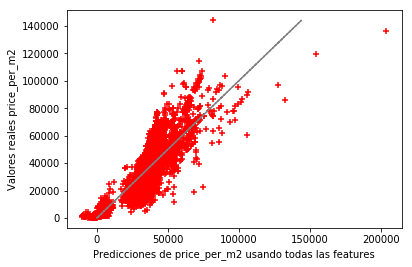

EMC: 10448033.952252245


In [5]:
lm = linear_model.LinearRegression()

X = Features
y = Target

model = lm.fit(X, y)
predictions = model.predict(X)

# Graficamos el modelo.

plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)

plt.xlabel("Predicciones de price_per_m2 usando todas las features")
plt.ylabel("Valores reales price_per_m2")
plt.plot(y,y, '-.',c='grey',zorder=11)
plt.show()

print ("EMC:", mean_squared_error(y, predictions))
prevMSE = mean_squared_error(y, predictions)


In [6]:
print ('Intercepto =', model.intercept_)
print ('RM = ', model.coef_)
print ('R2_train =', model.score(X, y))
print ("EMC:", mean_squared_error(y, predictions)) # error medio cuadrático
# MSE y RMSE son más grandes que antes. A su vez, R2 empeora su performance.

#print ('MSE:', metrics.mean_squared_error(true, pred))
#print ('RMSE:', np.sqrt(metrics.mean_squared_error(true, pred)))
#print ('R2:', metrics.r2_score(true, pred))

Intercepto = [8120.25222768]
RM =  [[ 6.62756387e-03  2.53347139e+04 -4.47018366e+05  8.51651022e+00
  -1.10040785e+01  1.53023288e+00 -1.23726314e+02  2.82402156e+02
  -2.57817858e+01 -2.48642362e+01 -2.31756065e+02  1.12232368e+04
  -1.12232368e+04  3.01570765e+03  2.94125577e+03  2.79583779e+03
   2.53634284e+03  2.27411036e+03  2.93170402e+03  1.69833933e+03
   3.02812461e+03 -8.53867619e+02 -8.86871753e+02 -1.15564334e+03
  -5.48676155e+03  3.82494443e+03  1.77238642e+03 -5.72673787e+03
   2.98967432e+03  9.41091588e+02 -7.85381059e+03 -8.78582634e+03]]
R2_train = 0.9155765788873326
EMC: 10448033.952252245


In [7]:
Features.columns

Index(['price', 'price_aprox_local_currency', 'price_aprox_usd',
       'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2',
       'rooms', 'prop_type_PH', 'prop_type_apartment', 'prop_type_house',
       'prop_type_store', 'curr_ARS', 'curr_USD',
       'state_Bs.As. G.B.A. Zona Norte', 'state_Bs.As. G.B.A. Zona Oeste',
       'state_Bs.As. G.B.A. Zona Sur', 'state_Buenos Aires Costa Atlántica',
       'state_Buenos Aires Interior', 'state_Capital Federal', 'state_Chubut',
       'state_Corrientes', 'state_Córdoba', 'state_Entre Ríos',
       'state_Mendoza', 'state_Misiones', 'state_Neuquén', 'state_Río Negro',
       'state_Salta', 'state_San Luis', 'state_Santa Fe',
       'state_Tierra Del Fuego', 'state_Tucumán'],
      dtype='object')

In [8]:
def train_test_rmse(feature_cols,total,df):
    X = df[feature_cols]
    y = df[total]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [9]:
#list(Features.columns)

In [10]:
# comparamos diferentes ensambles de features
print (train_test_rmse(list(Features.columns),list(Target.columns),properati))


3114.78063925406


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=53)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(29539, 32) (29539, 1)
(12660, 32) (12660, 1)


In [12]:
al_ridge = np.linspace(0.001, 0.3, 300)
al_lasso = np.linspace(0.1, 0.5, 300)
kf = KFold(n_splits=5, shuffle=True, random_state=12)

# Instanciamos los modelos

lm = LinearRegression()
lm_ridge_cv= RidgeCV(alphas=al_ridge, cv=kf, normalize=True)
lm_lasso_cv = LassoCV(alphas=al_lasso, cv=kf, normalize=True)

In [13]:
lm.fit(X_train, y_train)
lm_ridge_cv.fit(X_train, y_train)
lm_lasso_cv.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LassoCV(alphas=array([0.1    , 0.10134, ..., 0.49866, 0.5    ]), copy_X=True,
    cv=KFold(n_splits=5, random_state=12, shuffle=True), eps=0.001,
    fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=1,
    normalize=True, positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [14]:
print('Alpha Ridge:',lm_ridge_cv.alpha_,'\n'
      'Alpha LASSO:',lm_lasso_cv.alpha_,'\n')

Alpha Ridge: 0.005 
Alpha LASSO: 0.1 



In [15]:
# Calculamos el R2

print(" Score Train Lineal: %.2f\n" % lm.score(X_train, y_train),
      "Score Train Ridge : %.2f\n" % lm_ridge_cv.score(X_train, y_train),
      "Score Train Lasso : %.2f\n" %  lm_lasso_cv.score(X_train, y_train))

# Calculamos el RMSE

y_pred_tr_lm = lm.predict(X_train)
y_pred_tr_ridge = lm_ridge_cv.predict(X_train)
y_pred_tr_lasso = lm_lasso_cv.predict(X_train)

rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))

print(" Train RMSE lineal   : %.2f \n" % rmse(y_train,y_pred_tr_lm),
      "Train RMSE Ridge    : %.2f \n" % rmse(y_train,y_pred_tr_ridge),
      "Train RMSE Lasso    : %.2f \n" % rmse(y_train,y_pred_tr_lasso))

 Score Train Lineal: 0.92
 Score Train Ridge : 0.92
 Score Train Lasso : 0.92

 Train RMSE lineal   : 3252.46 
 Train RMSE Ridge    : 3253.06 
 Train RMSE Lasso    : 3255.10 



In [16]:
np.set_printoptions(precision=3, suppress=True)

(lm.intercept_, lm.coef_)

(array([8085.052]),
 array([[      0.007,   28836.019, -508797.148,       8.508,     -10.753,
               1.525,    -168.085,     350.865,      -0.392,      18.256,
            -368.729,   11346.158,  -11346.158,    3225.891,    3156.89 ,
            2998.218,    2766.361,    2420.109,    3167.197,    1101.   ,
            3188.367,    -711.073,   -1328.692,    -916.054,   -5906.327,
            4590.122,    1860.427,   -3712.816,    2360.046,    1025.729,
           -9981.046,   -9304.348]]))

In [17]:
(lm_ridge_cv.intercept_,lm_ridge_cv.coef_)

(array([10911.664]),
 array([[     0.007,     -0.   ,     -0.003,      8.042,    -10.487,
              1.484,   -168.032,    297.77 ,    -43.028,    -33.923,
           -405.618,  11287.52 , -11287.52 ,    457.583,    379.401,
            218.677,     -0.833,   -348.795,    398.115,  -1670.123,
            405.395,  -3454.148,  -4057.192,  -3686.195,  -8587.422,
           1866.286,   -949.263,  -6432.87 ,   -417.528,  -1723.108,
         -12677.9  , -11943.807]]))

In [18]:
(lm_lasso_cv.intercept_,lm_lasso_cv.coef_)

(-48.85260016230859,
 array([     0.007,     -0.   ,     -0.   ,      6.96 ,     -9.897,
             1.417,   -159.247,    265.752,     -0.   ,     -0.   ,
          -123.916,  22373.376,     -0.   ,    179.261,     62.175,
            -0.   ,   -208.598,   -437.154,    130.028,  -1150.618,
             0.   ,  -3591.298,  -3637.191,  -3629.983,  -8342.303,
          1440.594,   -836.94 ,  -5861.389,   -183.256,  -1845.886,
        -12123.349, -11720.925]))

In [19]:
Features.columns

Index(['price', 'price_aprox_local_currency', 'price_aprox_usd',
       'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2',
       'rooms', 'prop_type_PH', 'prop_type_apartment', 'prop_type_house',
       'prop_type_store', 'curr_ARS', 'curr_USD',
       'state_Bs.As. G.B.A. Zona Norte', 'state_Bs.As. G.B.A. Zona Oeste',
       'state_Bs.As. G.B.A. Zona Sur', 'state_Buenos Aires Costa Atlántica',
       'state_Buenos Aires Interior', 'state_Capital Federal', 'state_Chubut',
       'state_Corrientes', 'state_Córdoba', 'state_Entre Ríos',
       'state_Mendoza', 'state_Misiones', 'state_Neuquén', 'state_Río Negro',
       'state_Salta', 'state_San Luis', 'state_Santa Fe',
       'state_Tierra Del Fuego', 'state_Tucumán'],
      dtype='object')

In [20]:
# Hacemos las predicciones sobre la matriz de predictores del Test Set

y_pred_lm = lm.predict(X_test)
y_pred_ridge = lm_ridge_cv.predict(X_test)
y_pred_lasso = lm_lasso_cv.predict(X_test)

# Testeo final del modelo sobre Test Set

print(" Test RMSE lineal= %.2f\n" % rmse(y_test, y_pred_lm),
      "Test RMSE Ridge = %.2f\n" %  rmse(y_test, y_pred_ridge),
      "Test RMSE Lasso = %.2f" %  rmse(y_test, y_pred_lasso))

 Test RMSE lineal= 3190.90
 Test RMSE Ridge = 3191.36
 Test RMSE Lasso = 3188.75


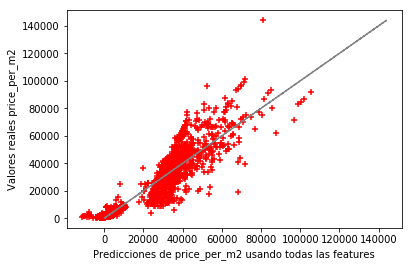

EMC: 10168128.154387739


In [21]:
# Graficamos el modelo.

plt.scatter(y_pred_lasso, y_test, s=30, c='r', marker='+', zorder=10)

plt.xlabel("Predicciones de price_per_m2 usando todas las features")
plt.ylabel("Valores reales price_per_m2")
plt.plot(y_test,y_test, '-.',c='grey',zorder=11)
plt.show()

print ("EMC:", mean_squared_error(y_test, y_pred_lasso))
prevMSE = mean_squared_error(y_test, y_pred_lasso)


In [22]:
prevMSE

10168128.154387739